# Sonidos sordos y sonoros

El aparato fonador humano crea dos tipos de sonidos dependiendo de si hay actividad en las cuerdas vocales. Los *sonidos sonoros* son aquellos donde nuestras cuerdas vocales vibran (se cierran y abren) a cierta frecuencia, la cual se conoce como frecuencia fundamental FO. Por el contrario en los *sonidos sordos* el aire de los pulmones pasa directamente por las cuerdas vocales sin que éstas vibren. 

Como ejemplo, si pronunciamos sostenidamente la vocal "a" /a/ (sonido sonoro) y nos tocamos la garganta podemos sentir una pequeña vibración; mientras que si hacemos el sonido de la "s" /s/ no vamos a sentir dicha vibración. 

En esta prática vamos a identificar de manera básica los sonidos sordos de los sonoros usando python, numpy, scipy, y matplotlib. Para ello vamos a ir por pasos:

1. Leer una señal en python
1. Calcular la potencia de la señal
1. Calcular el cruce-cero de la señal
1. Combinar los puntos previos para construir nuestro identificador

** Esta práctica está basada en las prácticas de las profesoras Inma Hernaez y Eva Navas, Universidad del País Vasco.

Ahora sí, manos a la obra!


## 1. Leer una señal en python
Una señal de habla es un conjunto de puntos de amplitud que van variando con el tiempo y que describen la onda.

De manera que podemos leer un archivo de audio y guardar nuestra señal en un arreglo de números flotantes. Para ello existen varias librerias especializadas para el análisis de audio, como librosa, soundfile, scipy. Esta vez vamos a usar scipy para leer archivos wav, scipy lee la señal y la guarda en un arreglo numpy. 

In [1]:
import numpy as np
from scipy.io import wavfile

# Nota: wavfile no acepta wav cuantizados a 16 bits
frecuencia_muestreo, senial = wavfile.read("aguadepanela2_3.wav")
# Frecuencia con la que se tomaron los puntos, por ejemplo 16kHz son 16000 puntos por segundo.
print(frecuencia_muestreo)
# Cantidad de muestras en la señal
muestras = senial.size
print(muestras)
# señal
print(senial)

44100
88733
[-8266 -8917 -8425 ...  2483  2630  3759]


Pero, ¿cómo luce la señal?. Para la ver la señal podemos usar matplolib para graficar tanto la forma de onda como el espectrograma. Para el espectrograma solo vamos a mostrar las frecuencias entre 0 y 10 kHz ya que con este rango es suficiente para caraterizar la voz humana.

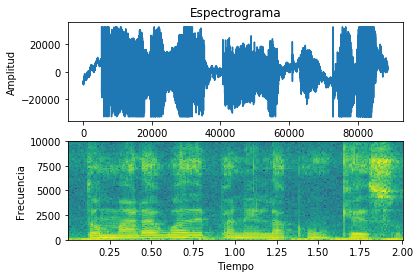

In [2]:
import matplotlib.pyplot as plot

plot.subplot(211)
plot.title("Espectrograma")

plot.plot(senial)
plot.xlabel("Muestra")
plot.ylabel("Amplitud")

plot.subplot(212)
plot.specgram(senial, Fs=frecuencia_muestreo, NFFT=512)
plot.axis(ymin=0, ymax=10000)
plot.xlabel("Tiempo")
plot.ylabel("Frecuencia")
plot.show()

## 2. Calcular la potencia de la señal [P]

Antes de entrar a diferenciar entre sonidos sonoros y sordos, debemos diferenciar entre el silencio y las partes de la señal donde hay voz. Para ello vamos a utilizar el cálculo de la potencia. La potencia es la cantidad de energía que hay en la señal. Partimos de la idea que los silencios contienen menos energía que las partes donde hay voz.

$P=lim_{N \rightarrow \infty}\frac{1}{2N + 1} \sum_{n=-N}^{N}{|x[n]|^2}$

Para hacer el análisis de tiempo reducido debemos obtener los frames, los frames son pequeños segmentos de la señal, normalmente van a estar solapados para tener un mejor análisis de los extremos.

![frames](./senial_frames.png)

In [3]:
"""
Vamos a realizar un análisis de tiempo reduciodo o corto para calcular la potencia de la señal. 
Para hacerlo, usamos una ventana (Hanning) con solapamiento. La potencia es calculada por frame.
"""

# Análisis de tiempo reducido en segundos
tamano_frame = 0.025  # longitud de la ventana
periodo_frame = 0.010  # desplazamiento de la ventana

# Numero de muestras por frame
tamano_frame = np.int(np.ceil(tamano_frame * frecuencia_muestreo))
periodo_frame = np.int(np.ceil(periodo_frame * frecuencia_muestreo))


# Frames
chunks = np.arange(0, muestras - tamano_frame, periodo_frame)
n_frames = chunks.size
# Total número de frames
print(n_frames)

# Organizar las muestras en cada frame
prev = chunks[0]
frames = tuple()
for x in chunks:
    frame = senial[prev:(x + tamano_frame)]
    frames += (np.transpose(frame),)
    prev = x + periodo_frame

frames = np.column_stack(frames)

print(frames)

199
[[-8266 -1581 -4526 ... 10895 10099  3315]
 [-8917 -3808 -4816 ... 10168 11914  2284]
 [-8425 -2059 -4964 ... 10582 13866  -996]
 ...
 [-2897 -1383 -1097 ...  4730  4697  2434]
 [-3433 -1885  -548 ...  4941  4787  3635]
 [-4215 -1458  -558 ...  4406  4629  3026]]


Ahora vamos a calcular la potencia, multiplicando nuestras frames por la ventana hanning, esto atenuará los valores en los extremos. Con eso habremos calculado la potencia de cada frame, sin embargo, necesitamos la misma cantidad de puntos que muestras en la señal. Para poder obtener la misma cantidad de puntos lo que hacemos es interpolar.

![Potencia por frame e interpolada](./potencia_interpolada.png)

In [5]:
import numpy.matlib
from scipy.interpolate import interp1d

# Calcular la potencia 
potencia = np.sum(np.power(np.multiply(frames,
                                       numpy.matlib.repmat(np.hanning(tamano_frame).reshape((tamano_frame, 1)),
                                                           1, n_frames)), 2), axis=0) / tamano_frame

# Total puntos en el arreglo potencia
print(potencia.size)

# Preparamos los puntos para interpolar
puntos = np.append([1], 1 + chunks + np.ceil(periodo_frame / 2))
puntos = np.append(puntos, [muestras])


# Añadimos los límites (dos puntos extras copiando el primero y el último punto en la potencia anteriormente
# calculadoa)
potencia = np.append([potencia[0]], potencia)
potencia = np.append(potencia, potencia[-1])

# Total puntos después de añadir extremos
print(potencia.size)

# Interpolamos
potencia = interp1d(puntos, potencia)(np.arange(1, muestras + 1))

#Total puntos después de interpolar
print(potencia.size)

199
201
88733


Ahora debemos separar el silencio de las partes con voz. Una forma de hacerlo, es sacar el promedio de la potencia en los primeros frames (que corresponden a silencio en el archivo de audio), y que dicho promedio sea nuestro umbral. 

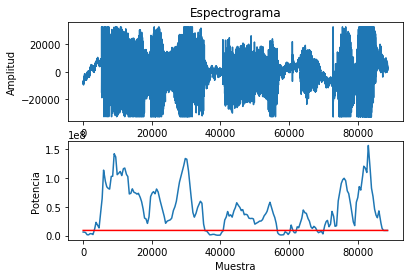

In [6]:
plot.subplot(211)
plot.title("Espectrograma")

plot.plot(senial)
plot.ylabel("Amplitud")

# Umbral de la potencia, calculado con las primeras 5000 muestras del arreglo potencia. 
umbral_potencia = np.mean(potencia[:5000])

plot.subplot(212)
plot.plot(potencia)

# Graficar una línea horizontal que marque el umbral.
plot.plot(np.ones(muestras)*umbral_potencia, 'r')
plot.xlabel("Muestra")
plot.ylabel("Potencia")

plot.show()

## 3. Calcular el cruce-cero de la señal

Una vez ya hemos distinguido entre voz y silencio podemos pasar a distinguir entre sonidos sonoros y sordos. Teniendo en cuenta que los los fragmentos periódicos de la señal cruzan menos veces el cero en el el eje vertical, es decir la amplitud, podemos promediar este número y clasificar así los sonidos.

En la señal las partes periódicas corresponden a sonidos sonoros, porque es donde existe una frecuencia en la vibración de las cuerdas vocales. Por el contrario los sonidos sordos no tiene esta características (se ven más erráticos en la gráfica de onda) y por ende cruzan más veces el cero. 

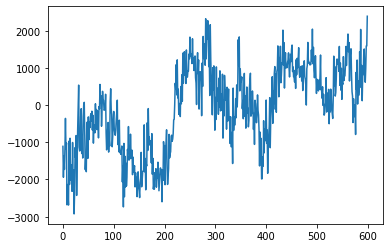

In [7]:
# Muestras que hacen parte del fonema /p/ que es un sonido sordo
plot.plot(senial[40000:40600])

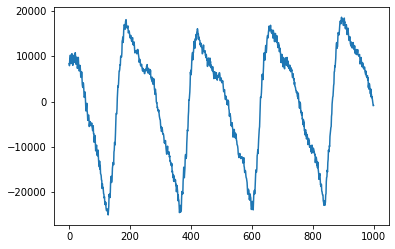

In [8]:
# Muestras que hacen parte del fonema /a/ que es un sonido sonoro
plot.plot(senial[45000:46000])

In [9]:
"""
   Al igual que en el cálculo de la potencia, vamos a hacer un análisis de tiempo reducido para sacar el 
   promedio de veces que la señal cruza el cero por frame, y después vamos a interpolar, para sacar todos
   los puntos de la señal.
"""
# Cambios de signo en la señal, es decir cruce cero.
cambio_signo = np.append([0], np.sign(senial))
cambio_signo = cambio_signo[1:] - cambio_signo[:-1]
cambio_signo = np.where(cambio_signo > 0, np.ones(muestras), np.zeros(muestras))

prev = chunks[0]
frames = tuple()

for x in chunks:
    frame = cambio_signo[prev:(x + tamano_frame)]
    frames += (np.transpose(frame),)
    prev = x + periodo_frame

frames = np.column_stack(frames)

# Normalizar
cruce_cero = np.sum(frames, axis=0)*(frecuencia_muestreo/tamano_frame)
# Total puntos en el arreglo cruce_cero
print(cruce_cero.size)

# Preparar puntos para interpolación
puntos = np.append([1], 1 + chunks + np.ceil(periodo_frame / 2))
puntos = np.append(puntos, [muestras])

# Añadir puntos de los extremos. 
cruce_cero = np.append([cruce_cero[0]], cruce_cero)
cruce_cero = np.append(cruce_cero, cruce_cero[-1])

# Total puntos después de añadir extremos
print(cruce_cero.size)

# Interpolar
cruce_cero = interp1d(puntos, cruce_cero)(np.arange(1, muestras + 1))
# Total puntos después de interpolar
print(cruce_cero.size)

199
201
88733


De nuevo debemos obtener un umbral para poder separa los dos tipos de sonidos. Idealmente deberíamos obtener dicho umbral con un anáisis estadístico del promedio del cruce cero para cada hablante con diferentes grabaciones. Por simplicidad, en este ejercicio vamos a asignar un valor de acuerdo al audio con el que estamos trabajando. 

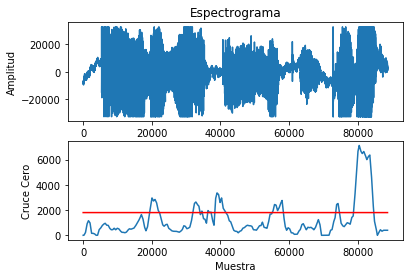

In [10]:
plot.subplot(211)
plot.title("Espectrograma")

plot.plot(senial)
plot.xlabel("Muestra")
plot.ylabel("Amplitud")

# Seleccionado para este ejercicio, teniendo en cuenta el audio 
umbral_cruce_cero = 1800

plot.subplot(212)
plot.plot(cruce_cero)

# Graficamos el umbral
plot.plot(np.ones(muestras)*umbral_cruce_cero, 'r')

plot.xlabel("Muestra")
plot.ylabel("Cruce Cero")

plot.show()

## 4. Distinguir entre sonidos sonoros y sordos

Finalmente lo que debemos hacer ahora es combinar el cálculo de la potencia con el de cruce cero. Podemos clasifica los sonidos sonoros como los segmentos de la señal con potencia más alta que la potencia promedio de los silencios y con cruce cero menor que cierto umbral.


In [11]:
# Identificación sonidos sonoros
sonoros = np.where(np.logical_and(cruce_cero<umbral_cruce_cero, potencia>umbral_potencia),
         np.ones(muestras), np.zeros(muestras))
sonidos_sonoros =np.multiply(senial,sonoros)

Graficamente se ve así:

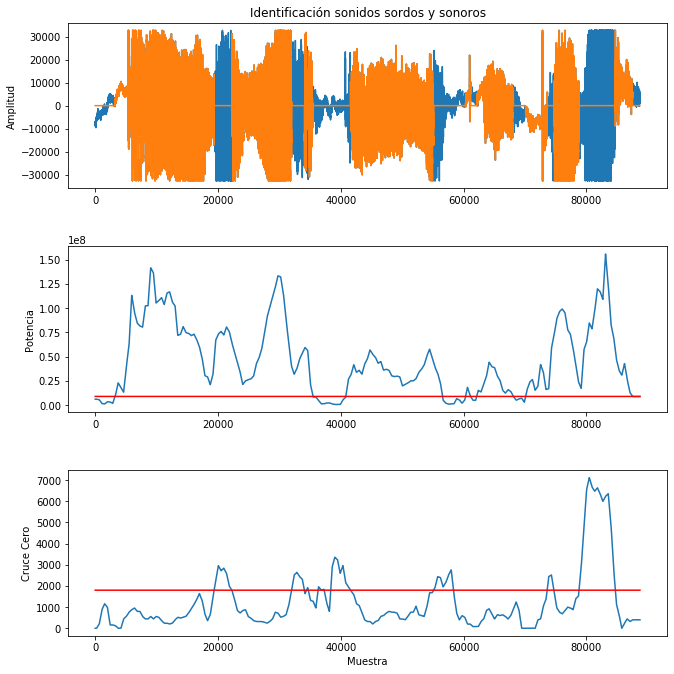

In [24]:
figure = plot.figure(figsize=(10,10))
ax1 = plot.subplot(311)
plot.title("Identificación sonidos sordos y sonoros")

ax1.plot(senial)
ax1.plot(sonidos_sonoros)
ax1.set_ylabel("Amplitud")


ax2 = plot.subplot(312)
ax2.plot(potencia)

ax2.plot(np.ones(muestras)*umbral_potencia, 'r')
ax2.set_ylabel("Potencia")

ax3 = plot.subplot(313)
ax3.plot(cruce_cero)
ax3.plot(np.ones(muestras)*umbral_cruce_cero, 'r')
ax3.set_xlabel("Muestra")
ax3.set_ylabel("Cruce Cero")

figure.tight_layout(pad=3.0)